## Techniques for tracking sagebrush plant community resiliency 
*A demonstration of using Google Earth Engine within Python to access rangeland plant cover data from the rangelands analysis platform (rangelands.app). We will track plant cover and assess how it has changed over time.*

## Background
**annual grass invasion**  
Around 57 million acres of western public lands are infested with invasive annual grasses, including cheatgrass (Bromus tectorum), field brome (B. arvensis), medusahead (Taeniatherum caput-medusae), and ventenata (Ventenata dubia).   
Cheatgrass is one of the most invasive weeds in Great Basin Rangelands and infests more than 56 million acres with an estimated 14% annual spread rate.   
Cheatgrass is able to capture moisture and nutrients earlier in the season than native grasses, which drastically alters structure, function, and disturbance regime of this ecosystem.  

**ecosytem resiliency**   
Resilience as the ability to maintain structure and function following alteration. Includes resistance to alterations and stability in the face of disturbance. Can be helpful or unhelpful.  
In sagebrush plant communities, one key indicator of ecosystem resiliency is the abundance of perennial forbs, grasses and shrubs, which can mediate the effects of disturbance. 

## Goals
1. Vizualize annual grass and forb cover in the western US to get a scope of the problem
2. Understand how plant cover has changed within my study area over time
4. Assess how plant cover has changed within different plant community groups over time  


3. Locating areas which have been invaded by annual grasses 
4. Maybe: Compare 2021 field estimates of cover to remotely sensed estimates. 

### Future work could include
1. Regression analysis to determine which areas have increased in annual grass cover in the past 20 years
2. Compare annual grass invasion in areas burned & unburned by wildfires in the past 20 years. 

## Project Motivation
I would like to understand how my observations during the past field season fit into larger spatial and temporal trends using remotely sensed tools. To accomplish this, I will 
try to identify areas which have been invaded by annual plants, and assess how shrub/perennial grass cover and wildfire history could play into a sites invasivibility. 
  
Additionally, I would like to gain experience using python in a way which relates and is useful for my dissertation project. 

## Workflow
General workflow (applies to all goals):  
- import cover estimates from GEE  
- import shapefiles for study area and sampling locations  

**Goal 1: Vizualize annual grass and forb cover in the western US to get a scope of the problem**
- Extract only a year of interest from RAP data
- Create layers for each plant functional group 
- Create folium map for each layer
- Repeat for additional years of interest

**Goal 2: Understand how plant cover has changed within my study area over time**
- Extract plant functional group cover for each sample point for each year
- Plot plant functional group cover over time by plot.
- Pull out plots which are increasing annual grass cover and explore more?? 

**Goal 3: Assess how plant cover has changed within different plant community groups over time**
- Stratify by plant community group using cutoff values for shrubs and perennial grasses/forbs
- Extract annual grass cover over time within strata
- Plot these data over time, seperated by plant community group

## Datasets

**The main dataset we will be using is the Rangeland Analysis Platform estimates of vegetation cover.**

These data are estimates from 1984 to present of percent cover by plant functional group, in the Western US. The estimates were produced by combining approximately 60,000 field plots from the BLM Assessment, Inventory, and Monitoring (AIM) datasets and NRCS National Resources Inventory (NRI) with the historical Landsat satellite record. Utilizing the cloud computing power of Google Earth Engine and Google AI Platform, annual cover estimates are predicted across the western half of the U.S. at 30m resolution.The plant funcational groups included are annual grass and forbs, perennial grass and forbs, shrubs, and trees. Other non-living functional groups include bare ground and litter (dead and detached plant material). 

Allred, B.W., B.T. Bestelmeyer, C.S. Boyd, C. Brown, K.W. Davies, M.C. Duniway, L.M. Ellsworth, T.A. Erickson, S.D. Fuhlendorf, T.V. Griffiths, V. Jansen, M.O. Jones, J. Karl, A. Knight, J.D. Maestas, J.J. Maynard, S.E. McCord, D.E. Naugle, H.D. Starns, D. Twidwell, and D.R. Uden. 2021. Improving Landsat predictions of rangeland fractional cover with multitask learning and uncertainty. Methods in ecology and evolution. http://dx.doi.org/10.1111/2041-210x.13564

*These data are conveniently available on Google Earth Engine. Yay!*


**Additionally, we will be using outlines of my study area in southern Idaho at Rinker Rock Creek Ranch near Hailey, ID.** I will explain those more when we start working with them later on. 


## Set yourself up

In [93]:
#load in environments

import ee
from IPython.display import Image
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium # For super-cool interactive maps
import branca
import branca.colormap as cm

In [2]:
ee.Initialize()

In [3]:
%cd "C:\Users\harr4718\Documents\GitHub\GIS_programming_F21"

C:\Users\harr4718\Documents\GitHub\GIS_programming_F21


# Getting started - import datasets  
## Bring in rangeland plant cover data from GEE
https://support.rangelands.app/article/62-export-vegetation-cover-rasters

In [4]:
# Create an ee.ImageCollection variable named "cover"
cover =  ee.ImageCollection("projects/rangeland-analysis-platform/vegetation-cover-v2") # this is an image collection of plant cover

Some information about this dataset from the RAP website:

 These data represent rangeland cover estimates described in Allred et al.(2021).
- Version 2: 1984-2020
- Bands are: 
    Band 1 - annual forb and grass
    Band 2 - bare ground
    Band 3 - litter
    Band 4 - perennial forb and grass
    Band 5 - shrub
    Band 6 - tree
    Band 7 - annual forb and grass uncertainty
    Band 8 - bare ground uncertainty
    Band 9 - litter uncertainty
    Band 10 - perennial forb and grass uncertainty
    Band 11 - shrub uncertainty
    Band 12 - tree uncertainty
- So bands 1-6 are plant functional group cover, bands 7-12 are uncertainy estimates
No Data value = 65535
Uncertainty values are scaled by 100

- Data are in WGS84 Geographic Coordinate System (EPSG:4326)
- spatial resolution is approximately 30m.

In [5]:
cover.first().getInfo() #all of the cover bands are values 0 - 255 

{'type': 'Image',
 'bands': [{'id': 'AFGC',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [116041, 86027],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00026949458523585647,
    0,
    -124.76979458874112,
    0,
    -0.00026949458523585647,
    49.01163274391904]},
  {'id': 'BG',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [116041, 86027],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00026949458523585647,
    0,
    -124.76979458874112,
    0,
    -0.00026949458523585647,
    49.01163274391904]},
  {'id': 'LTR',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [116041, 86027],
   'crs': 'EPSG:4326',
   'crs_transform': [0.00026949458523585647,
    0,
    -124.76979458874112,
    0,
    -0.00026949458523585647,
    49.01163274391904]},
  {'id': 'PFGC',
   'data_type': {'type': 'PixelType',
    'p

In [6]:
#what are the band names 
print(cover.first().bandNames().getInfo())

['AFGC', 'BG', 'LTR', 'PFGC', 'SHR', 'TREE', 'AFGCSTD', 'BGSTD', 'LTRSTD', 'PFGCSTD', 'SHRSTD', 'TREESTD']


In [7]:
#create a list of band names for cover - for now we are not interested in uncertainty
cover_bandNames = ['AFGC', 'BG', 'LTR', 'PFGC','SHR','TREE']

In [8]:
# Define the operative scale of the dataset.  This is important for defining how EE does its analyses.
#    This should be the resolution of the data product.
scale = 30 #m

## Bring in data from sampling locations and area of interest near ranch

In [10]:
#within current working directory 
%cd #python magic for current directory
print("Documents/GitHub/GIS_programming_F21")

C:\Users\harr4718
Documents/GitHub/GIS_programming_F21


Bring in sampling point locations, which are called wiggleroom becuase there were extra points which were not actually sampled. 

In [11]:
wiggleroom = gpd.read_file('Documents/GitHub/GIS_programming_F21/datasets/Ranch/FuelLoad_points_shape/FuelLoad_points.shp') #sampling point locations

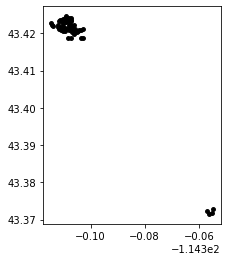

In [78]:
#quickly plot these points 
fig, ax = plt.subplots()
wiggleroom.plot(ax=ax, color = 'black', markersize = 15)

In [17]:
# Define the location of interest for the ranch (near Hailey, ID)
ranch_lon = -114.418
rach_lat =  43.368564 
ranch_poi = ee.Geometry.Point(ranch_lon, rach_lat) 

# Define the operative scale of the dataset.  This is important for defining how EE does its analyses.
#    This should be the resolution of the data product.
scale = 30  # scale in meters

# Goal 1: Vizualize annual grass and forb cover in the western US to get a scope of the problem
- Extract only one year of interest from RAP data
- Create layers for each plant functional group 
- Create folium map for each layer

## lets start with annual forb and grass cover from 2020 

In [86]:
# Calculate and print the mean value of the LST collection at the point.
A_2020 = cover.filterDate('2020').select('AFGC').mean()

In [19]:
roi = ranch_poi.buffer(1e4) #notice this is Roi for REGION, not POINT (poi)

In [84]:
# Create a URL to the styled image for region around ranch
url = A_2020.getThumbUrl({
  'min': 0,  'max': 75,'dimensions': 512, 'region': roi,
  'palette': ["darkgreen", "lightgreen", "lightblue", "darkblue"]})
print(url)

# Display the thumbnail
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a1b46a627ecb7a588654d3749c943bd-298aa64aa9402573088775ebdd1719d2:getPixels


### Generate additional years of interest

In [87]:
A_2015= cover.filterDate('2015').select('AFGC').mean()
A_2010= cover.filterDate('2010').select('AFGC').mean()
A_2005= cover.filterDate('2005').select('AFGC').mean()
A_2000= cover.filterDate('2000').select('AFGC').mean()
A_1990= cover.filterDate('1990').select('AFGC').mean()

## Create a folium map

In [88]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)


In [103]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Create a folium map object.
my_map = folium.Map(location=[43.3, -114.418], zoom_start=5)

#define the color palette and max/min values 
vmin = 0
vmax = 60
BL_OR = ['black', 'gray', 'yellow', 'orange'] 

#set parameters
params = {'min': vmin, 'max': vmax, 'palette': BL_OR}

#add layers to map using params         
my_map.add_ee_layer(A_2020, params, '2020 Annual grass & forb cover)')
my_map.add_ee_layer(A_2010, params, '2010 Annual grass & forb cover)')
my_map.add_ee_layer(A_2000, params, '2000 Annual grass & forb cover')
my_map.add_ee_layer(A_1990, params, '1990 Annual grass & forb cover)')
#add colorbar
colormap = cm.LinearColormap(PuBuGn, vmin=vmin, vmax=vmax)
colormap.caption = "Percent Cover"
colormap.add_to(my_map) 
#add layer control
folium.LayerControl(collapsed = False).add_to(my_map)# Add a layer control panel to the map.


display(my_map)# Display the map

# Goal 2: Understand how plant cover has changed within my study area over time
How has plant cover changed in the area with 10 km around Rock Creek Ranch? 

### start by extracting annual grass cover within this area over for each year of the dataset (1984-current)

In [25]:
#import the range cover data from GEE
cover =  ee.ImageCollection("projects/rangeland-analysis-platform/vegetation-cover-v2") # this is an image collection of plant cover

In [26]:
# Define the location of interest for the Ranch.
ranch_lon = -114.418
rach_lat =  43.368564 
ranch_poi = ee.Geometry.Point(ranch_lon, rach_lat) 

# Define the operative scale of the dataset.  This is important for defining how EE does its analyses.
#    This should be the resolution of the data product.
scale = 30  # scale in meters

In [27]:
#create a area of interest with buffer around the ranch point 
ranch_roi = ranch_poi.buffer(1e3) #10,000 m = 10 km 

### 1. Filter dataset to only annual cover 

In [28]:
#what are the band names 
print(cover.first().bandNames().getInfo())

['AFGC', 'BG', 'LTR', 'PFGC', 'SHR', 'TREE', 'AFGCSTD', 'BGSTD', 'LTRSTD', 'PFGCSTD', 'SHRSTD', 'TREESTD']


In [29]:
#create region reduction function 
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

**The band we care about for annual plant cover is AFGC = annual forb and grasses**

In [30]:
ag_cover_collection = cover.select('AFGC')  #image collection for all the years, only shrub cover 
print(type(ag_cover_collection)) #image collection

<class 'ee.imagecollection.ImageCollection'>


### 2. Reduce dataset to average cover around the ranch

In [31]:
#create a method for how and where we would like the cover data reduced

reduce_ag = create_reduce_region_function(
    geometry=ranch_roi, reducer=ee.Reducer.mean(), scale=scale, crs='EPSG:3310')

In [32]:
type(ranch_roi)

ee.geometry.Geometry

In [33]:
#use the reduction method you just created to filter and take out null values. 
#this converts the image collection to a feature collection

ag_stat_fc = ee.FeatureCollection(ag_cover_collection.map(reduce_ag)).filter(
    ee.Filter.notNull(ag_cover_collection.first().bandNames())) #filter out null values

### 3. format into a table

In [34]:
#converts feature collection to an ee.Dictionary

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [35]:
ag_dict = fc_to_dict(ag_stat_fc).getInfo() #result is a python dictionary

In [36]:
print(type(ag_dict), '\n')
for prop in ag_dict.keys():
    print(prop + ':', ag_dict[prop][0:3] + ['...'])

<class 'dict'> 

AFGC: [1.581007996095589, 1.2649074121365858, 1.724521170642014, '...']
millis: [441763200000, 473385600000, 504921600000, '...']
system:index: ['1984', '1985', '1986', '...']


In [37]:
#convert the python dictionary to a pandas dataframe
ag_df = pd.DataFrame(ag_dict)

In [38]:
#Preview the DataFrame and check the column data types.
ag_df.head(5)
print(ag_df.dtypes)

#the system:time_start column is data in milliseconds

AFGC            float64
millis            int64
system:index     object
dtype: object


**since these data are just annual, we do not need to worry about converting milliseconds to year, date, month. We just want the year, which is already provided to us in 'system:index' column**

In [39]:
#Rename and drop columns
ag_df = ag_df.rename(columns={
    'system:index': 'year'
}).drop(columns=['millis'])
ag_df.head(5)

,AFGC,year
0,1.581008,1984
1,1.264907,1985
2,1.724521,1986
3,2.701455,1987
4,2.959418,1988


In [40]:
ag_df.dtypes #Check the data type of each column.
ag_df.year = ag_df['year'].astype(str).astype(int) #need to convert year to an integer
ag_df.dtypes #check that everything is in order

## graph these data

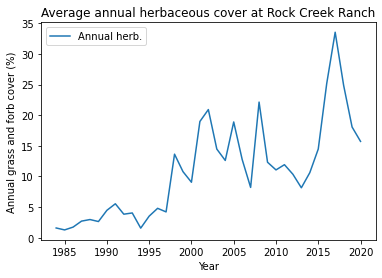

In [42]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6,4))

ag_df.plot(x = 'year', y = 'AFGC', label="Annual herb.", ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Annual grass and forb cover (%)")
plt.title("Average annual herbaceous cover at Rock Creek Ranch")
plt.savefig('AG_rockCreek.tif')

How to add a trendline to matplotlib scatter plots: https://widu.tumblr.com/post/43624347354/matplotlib-trendline

## Add other plant functional groups of interst: shrub, perennial, and bare ground

In [104]:
#select only the plant functional groups that we care about
bg_cover_collection = cover.select('BG')  
sh_cover_collection = cover.select('SHR') 
pg_cover_collection = cover.select('PFGC') 

In [105]:
#create a method for how and where we would like the cover data reduced
reduce_method= create_reduce_region_function(
    geometry=ranch_roi, reducer=ee.Reducer.mean(), scale=scale, crs='EPSG:3310')

In [106]:
bg_stat_fc = ee.FeatureCollection(bg_cover_collection.map(reduce_method)).filter(
    ee.Filter.notNull(bg_cover_collection.first().bandNames())) #filter out null values
sh_stat_fc = ee.FeatureCollection(sh_cover_collection.map(reduce_method)).filter(
    ee.Filter.notNull(sh_cover_collection.first().bandNames())) #filter out null values
pg_stat_fc = ee.FeatureCollection(pg_cover_collection.map(reduce_method)).filter(
    ee.Filter.notNull(pg_cover_collection.first().bandNames())) #filter out null values

In [107]:
bg_dict = fc_to_dict(bg_stat_fc).getInfo() #result is a python dictionary
sh_dict = fc_to_dict(sh_stat_fc).getInfo() #result is a python dictionary
pg_dict = fc_to_dict(pg_stat_fc).getInfo() #result is a python dictionary

In [108]:
#convert the python dictionary to a pandas dataframe
bg_df = pd.DataFrame(bg_dict)
sh_df = pd.DataFrame(sh_dict)
pg_df = pd.DataFrame(pg_dict)

In [109]:
#Rename and drop columns
bg_df = bg_df.rename(columns={ 'system:index': 'year'}).drop(columns=['millis'])
sh_df = sh_df.rename(columns={'system:index': 'year'}).drop(columns=['millis'])
pg_df = pg_df.rename(columns={'system:index': 'year'}).drop(columns=['millis'])

In [49]:
#need to convert year to an integer
bg_df.year = bg_df['year'].astype(str).astype(int)
sh_df.year = bg_df['year'].astype(str).astype(int)
pg_df.year = bg_df['year'].astype(str).astype(int)

In [50]:
#create a new dataframe for all of the functional group cover 
pfc_cover = ag_df
pfc_cover['BG'] = bg_df['BG']
pfc_cover['SHR'] = sh_df['SHR']
pfc_cover['PFGC'] = pg_df['PFGC']

In [51]:
pfc_cover.head(5)

,AFGC,year,BG,SHR,PFGC
0,1.581008,1984,8.087316,27.708942,40.180817
1,1.264907,1985,8.137443,33.476161,33.250980
2,1.724521,1986,9.620648,31.226031,34.269286
3,2.701455,1987,10.890337,30.675371,31.269948
4,2.959418,1988,9.659657,28.495632,35.317749


## plot these data using matplotlib

Text(0.5, 1.0, 'Average plant cover within 10 km area of Rock Creek Ranch')

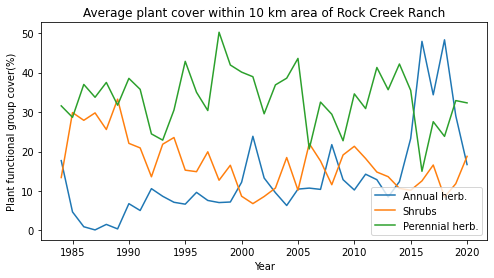

In [120]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,4))

pfc_cover.plot(x = 'year', y = 'AFGC', label="Annual herb.", ax=ax)
#pfc_cover.plot(x = 'year', y = 'BG', ax=ax)
pfc_cover.plot(x = 'year', y = 'SHR', label="Shrubs", ax=ax)
pfc_cover.plot(x = 'year', y = 'PFGC', label="Perennial herb.",ax=ax)
plt.legend(loc='lower right')

ax.set_xlabel("Year")
ax.set_ylabel("Plant functional group cover(%)")
plt.title("Average plant cover within 10 km area of Rock Creek Ranch")

## compare annual cover to bare ground

Text(0.5, 1.0, 'Average annual herbaceous plant and bare ground cover \n within 10 km area around Rock Creek Ranch')

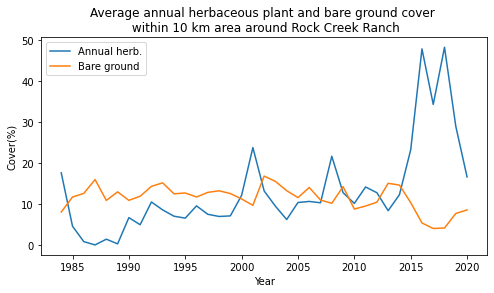

In [122]:
fig, ax = plt.subplots(figsize=(8,4))

pfc_cover.plot(x = 'year', y = 'AFGC', label="Annual herb.", ax=ax)
pfc_cover.plot(x = 'year', y = 'BG', label="Bare ground", ax=ax)
plt.legend(loc='upper left')

ax.set_xlabel("Year")
ax.set_ylabel("Cover(%)")
plt.title("Average annual herbaceous plant and bare ground cover \n within 10 km area around Rock Creek Ranch")

# Goal 3: Assess how plant cover has changed within different plant community groups over time

**first we will need to stratify into different plant community groups**  
  
 I will seperate the landscape based on perennial herbaceous plant and shrub cover. **Areas of high and low shrub and perennial vegetation were delineated at 25 and 30% cover, respectively.**  Selecting sampling locations using PFGC and SHR values from 2019.  To accomplish this, I will use a **mask** by percent cover values. 
Helpful links: 
https://developers.google.com/earth-engine/guides/image_relational#colab-python
https://gis.stackexchange.com/questions/359852/how-do-i-extract-pixels-of-specific-values-from-a-raster-in-google-earth-engine/359864

Here are the arguments for updating masks

https://gis.stackexchange.com/questions/359852/how-do-i-extract-pixels-of-specific-values-from-a-raster-in-google-earth-engine/359864
// eq() - equalsAreas of high and low shrub and perennial vegetation were delineated at 25 and 30% cover, respectively.
// neq() - not equals
// lt() - less than 
// gt() - greater than
// lte() - less than or equals
// gte() - greater than or equals
// and() - logical and
// or() - logical or

In [123]:
#gather 2019 cover for shrubs, perennials, and annuals
P_2019 = cover.filterDate('2019').select('PFGC').mean()
A_2019 = cover.filterDate('2019').select('AFGC').mean()
SH_2019 = cover.filterDate('2019').select('SHR').mean()

## seperate out shrub and perennial cover by cover cutoff points

In [126]:
#high shrub areas have over 25% cover
HS_2019 = SH_2019.updateMask(SH_2019.gte(25)) #gte is greater than or equal to

#low shrub areas are under 25% cover 
LS_2019 = SH_2019.updateMask(SH_2019.lt(25)) #lt is less than

#high perennial areas have over 30% cover
HP_2019 = P_2019.updateMask(P_2019.gte(30)) #gte is greater than or equal to

#low shrub perennial are under 30% cover 
LP_2019 = P_2019.updateMask(P_2019.lt(30)) #lt is less than

In [127]:
# Create a URL to the styled image for region around ranch
#this is just to check that the masking worked
url = HS_2019.getThumbUrl({
  'min': 0,  'max': 100,'dimensions': 512, 'region': roi,
  'palette': ["darkgreen", "lightgreen", "lightblue", "darkblue"]})
print(url)

# Display the thumbnail
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b29b1cf57b4d8d57f62d120c637078f2-20903d1e6369eaf638cc7ae53799e0c4:getPixels


In [130]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Create a folium map object.
my_map = folium.Map(location=[43.3, -114.418], zoom_start=5)

#shrubs
HS_params = {'min': 0, 'max': 75, 'palette': ["d7191c"]}
my_map.add_ee_layer(HS_2019, HS_params, 'High Shrub (>25% cover)') #UPDATE HERE

LS_params = {
  'min': 0, 'max': 75, 'palette': ["fdae61"]}
my_map.add_ee_layer(LS_2019, LS_params, 'Low Shrub (<25% cover)') #UPDATE HERE

#perenials
LP_params = {'min': 0, 'max': 75, 'palette': ["abd9e9"]}
my_map.add_ee_layer(LP_2019, LP_params, 'Low Perennial (<30% cover)') #UPDATE HERE

HP_params = {'min': 0, 'max': 75, 'palette': ["2c7bb6"]}
my_map.add_ee_layer(HP_2019, HP_params, 'High Perennial (>30% cover)') #UPDATE HERE


folium.LayerControl(collapsed = False).add_to(my_map)# Add a layer control panel to the map.
display(my_map)# Display the map.
my_map.save("Simple_shrubPG_layers.html")

In [131]:
#mask the annual grass layer by high and low shrub and perennial grasses

HSHG = A_2019.multiply(HS_2019).multiply(HP_2019)
HSLG = A_2019.multiply(HS_2019).multiply(LP_2019)
LSHG = A_2019.multiply(LS_2019).multiply(HP_2019)
LSLG = A_2019.multiply(LS_2019).multiply(LP_2019)
#not sure this is working - I think this is all areas that are both high shrub or high perennials. we want only those which are both! 

In [132]:
# Create a URL to the styled image for region around ranch
url = HSHG.getThumbUrl({
  'min': 0,  'max': 50,'dimensions': 512, 'region': roi,
  'palette': ["darkgreen", "lightgreen", "lightblue", "darkblue"]})
print(url)

# Display the thumbnail
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a1a220b19cefe4dd88d07c74c7bed902-00985140a1f9f1fe88ffd72b53e224ba:getPixels


## Map the strata

In [156]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Create a folium map object.
my_map = folium.Map(location=[43.3, -114.418], zoom_start=5)

#define the color palette and max/min values 
#min and max are the same for every layer
vmin = 0
vmax = 1
#color palletes are different tho 
HSHS_colors = ['orange', 'orange']
HSLG_colors = ['darkred', 'darkred']
LSHG_colors = ['teal', 'teal']
LSLG_colors = ['cadetblue', 'cadetblue']

HS_params = {'min': vmin, 'max': vmax, 'palette': HSHS_colors} #brown
my_map.add_ee_layer(HSHG, HS_params, 'HSHG') #UPDATE HERE

LS_params = {'min': vmin, 'max': vmax, 'palette': HSLG_colors} #tan
my_map.add_ee_layer(HSLG, LS_params, 'HSLG') #UPDATE HERE

LP_params = {'min': vmin, 'max': vmax, 'palette': LSHG_colors} #light teal
my_map.add_ee_layer(LSHG, LP_params, 'LSHG') #UPDATE HERE

HP_params = {'min': vmin, 'max': vmax, 'palette': LSLG_colors} #dark teal
my_map.add_ee_layer(LSLG, HP_params, 'LSLG') #UPDATE HERE


#add colorbars
colormap1 = cm.LinearColormap(HSHS_colors, vmin=vmin, vmax=vmax)
colormap1.caption = "HSHG"
colormap1.add_to(my_map) 

colormap2 = cm.LinearColormap(HSLG_colors, vmin=vmin, vmax=vmax)
colormap2.caption = "HSLG"
colormap2.add_to(my_map) 

colormap3 = cm.LinearColormap(LSHG_colors, vmin=vmin, vmax=vmax)
colormap3.caption = "LSHG"
colormap3.add_to(my_map) 

colormap4 = cm.LinearColormap(LSLG_colors, vmin=vmin, vmax=vmax)
colormap4.caption = "LSLG"
colormap4.add_to(my_map) 

#add layer control
folium.LayerControl(collapsed = False).add_to(my_map)# Add a layer control panel to the map.

display(my_map)# Display the map.

### Sampling occured within these strata

In [62]:
wiggleroom = gpd.read_file('Documents/GitHub/GIS_programming_F21/datasets/Ranch/FuelLoad_points_shape/FuelLoad_points.shp') #sampling point locations

update which plots were actually sampled

In [64]:
##bring in info about which plots were actually sampled this summer and what their new plot names are
data = [['101T', 'HSHG_LRC_T'], ['102T', 'HSHG_T_7'], ['103T', 'HSHG_T_6'], ['104T', 'HSHG_T_2'], ['105T', 'HSHG_C_1'], ['101C', 'HSHG_LRC_C'],
        ['102C', 'HSHG_C_8'], ['103C', 'HSHG_C_5'], ['104C', 'HSHG_C_6'], ['105C', 'HSHG_T_1'], ['201T', 'HSLG_T_5'], ['202T', 'HSLS_T_6'], ['203T', 'HSLG_T_1'],
        ['204T', 'HSLG_T_3'], ['201C', 'HSLG_C_4'], ['202C', 'HSLG_C_3'], 
        ['203C', 'HSLG_C_1'], ['204C', 'HSLG_C_2'], ['301T', 'LSHG_LRC_T'], ['302T', 'LSHG_T_7'], 
        ['303T', 'LSHG_T_3'], ['304T', 'LSHG_T_2'], ['305T', 'LSHG_T_1'], ['301C', 'LSHG_LRC_C'], ['302C', 'LSHG_C_5'], ['303C', 'LSHG_C_4'],
        ['304C', 'LSHG_C_3'], ['401T', 'LSLG_T_2'], ['401T', 'LSLG_T_5'], ['401C', 'LSLG_C_1'], ['402C', 'LSLG_C_5']]

sampled = pd.DataFrame(data, columns = ['new_name', 'old_name'])
sampled

,new_name,old_name
0,101T,HSHG_LRC_T
1,102T,HSHG_T_7
2,103T,HSHG_T_6
3,104T,HSHG_T_2
4,105T,HSHG_C_1
5,101C,HSHG_LRC_C
6,102C,HSHG_C_8
7,103C,HSHG_C_5
8,104C,HSHG_C_6
9,105C,HSHG_T_1


In [65]:
#Figure out which of the old name plots in wiggle room were actually sampled this summer 
good_idx = wiggleroom['Name'].isin(sampled['old_name'])
summer2021 = wiggleroom.loc[good_idx]
summer2021

,Name,Shrub,PG,BGround,Notes,GlobalID,plotID,Field,geometry
0,HSLG_T_1,40,28,3,None,b59cf147-124e-4e7a-bf72-3f4eb5b9a907,None,0,POINT Z (-114.40705 43.41868 0.00000)
1,HSLG_C_1,33,25,4,None,4de3a140-ba3c-488f-a1da-6b28aa8fd6ca,None,0,POINT Z (-114.40840 43.41868 0.00000)
2,HSHG_C_1,33,32,5,None,f1de3649-a702-4d76-bf3e-1dd8b1cc8156,None,0,POINT Z (-114.40356 43.41868 0.00000)
3,HSHG_T_1,37,36,5,None,266b1124-d426-4a6b-acad-74d4aad7c7c1,None,0,POINT Z (-114.40274 43.41867 0.00000)
4,HSLG_C_2,36,29,6,None,253c1d22-10b1-4875-9a99-e1191bc9a3e2,None,0,POINT Z (-114.40624 43.42218 0.00000)
6,HSLG_T_3,36,28,8,None,d337ec43-aa85-4a3b-a140-03ac06863f5c,None,0,POINT Z (-114.40625 43.42003 0.00000)
8,HSLG_C_3,37,22,8,None,9fda9642-7ba3-4f79-a703-634c8ee94849,None,0,POINT Z (-114.40517 43.42029 0.00000)
9,HSLG_C_4,26,25,12,None,063ebcc9-83a0-4bc2-a7c1-10bcde9a39f3,None,0,POINT Z (-114.40463 43.42057 0.00000)
10,HSLG_T_5,42,19,2,None,4707c3c0-f784-4335-b810-d75500573c59,None,0,POINT Z (-114.41002 43.42164 0.00000)
11,HSLS_T_6,47,27,3,None,a99ede42-907e-4c7e-99d9-b30c627ba2cd,None,0,POINT Z (-114.40948 43.42138 0.00000)


In [66]:
#bring in new plot names 
# I am going to sort them by a common column and then join 
summer2021
summer2021 = summer2021.sort_values(by = 'Name')
summer2021

names = sampled.sort_values(by = 'old_name')
names

,new_name,old_name
4,105T,HSHG_C_1
7,103C,HSHG_C_5
8,104C,HSHG_C_6
6,102C,HSHG_C_8
5,101C,HSHG_LRC_C
0,101T,HSHG_LRC_T
9,105C,HSHG_T_1
3,104T,HSHG_T_2
2,103T,HSHG_T_6
1,102T,HSHG_T_7


In [67]:
summer2021['New_plot_names'] = sampled['new_name']

In [68]:
print(cover.first().bandNames().getInfo())

['AFGC', 'BG', 'LTR', 'PFGC', 'SHR', 'TREE', 'AFGCSTD', 'BGSTD', 'LTRSTD', 'PFGCSTD', 'SHRSTD', 'TREESTD']


In [69]:
#create list of plot names, lat and long

#extract lat and long for each point
summer2021['lon'] = summer2021.geometry.y
summer2021['lat'] = summer2021.geometry.x

#make list of names, lat and long
plot_names = list(summer2021['Name'])
plot_lats = list(summer2021['lat'])
plot_longs = list(summer2021['lon'])

In [70]:
summer2021['New_plot_names'] = sampled['new_name']

Use a loop to extract plant cover values for each plot location, every year and all the plant functional groups

In [135]:
list_of_bands = ['AFGC', 'BG', 'LTR', 'PFGC', 'SHR', 'TREE', 'AFGCSTD', 'BGSTD', 'LTRSTD', 'PFGCSTD', 'SHRSTD', 'TREESTD']

cover_data = [] #create empty list to append data
for name,lat,long in zip(plot_names, plot_lats, plot_longs):
    print(name, "is at",lat, ",", long)
    #define the sampled location
    sample_location = ee.Geometry.Point(lat, long)
    sample_location_buffered = sample_location.buffer(10) #small buffer around the point #unit is in m
    #create a method for how and where we would like the cover data reduced
    reduce_function = create_reduce_region_function(
        geometry=sample_location_buffered, reducer=ee.Reducer.mean(), scale=scale, crs='EPSG:3310')
    for band in list_of_bands:
        cover_collection = cover.select(band)     
        stat_fc = ee.FeatureCollection(cover_collection.map(reduce_function)).filter(
            ee.Filter.notNull(cover_collection.first().bandNames())) #filter out null values
        as_dict = fc_to_dict(stat_fc).getInfo()
        as_df = pd.DataFrame(as_dict)
        as_df = as_df.rename(columns={'system:index': 'year'}).drop(columns=['millis'])
        as_df.year = as_df['year'].astype(str).astype(int)
        pfc_cover[band] = as_df[band]
        pfc_cover['plot_name'] = name
    #use the reduction method you just created to filter and take out null values. 
    #this converts the image collection to a feature collection
    #convert data from wide to long format
    pfc_cover_long = pd.melt(pfc_cover, id_vars = ['year', 'plot_name'], 
                             value_vars=list_of_bands, 
                             var_name='PFC', value_name='cover')
    cover_data.append(pfc_cover_long)
# see pd.concat documentation for more info
cover_data = pd.concat(cover_data)

HSHG_C_1 is at -114.40355768899997 , 43.41868083700007
HSHG_C_5 is at -114.40409952199997 , 43.42083232700003
HSHG_C_6 is at -114.40355195699999 , 43.42082976800003
HSHG_C_8 is at -114.40732432099998 , 43.422184352000045
HSHG_LRC_C is at -114.35477351399999 , 43.37286285000005
HSHG_LRC_T is at -114.355042433 , 43.371783779000054
HSHG_T_1 is at -114.40274236299996 , 43.41866848400008
HSHG_T_2 is at -114.40732045699997 , 43.42110080000003
HSHG_T_6 is at -114.40947937299995 , 43.42109536300006
HSHG_T_7 is at -114.41002304899996 , 43.42110027600006
HSLG_C_1 is at -114.40840296099998 , 43.41867540000004
HSLG_C_2 is at -114.40624376499994 , 43.422177661000035
HSLG_C_3 is at -114.40517173999996 , 43.42029179900004
HSLG_C_4 is at -114.40463127799995 , 43.42057168200006
HSLG_T_1 is at -114.40705413899997 , 43.41867789300005
HSLG_T_3 is at -114.40624986799997 , 43.42002735900007
HSLG_T_5 is at -114.41001718899997 , 43.42163928200006
HSLS_T_6 is at -114.40947943999998 , 43.42137688400004
LSHG_C_3

### now we have a dataset which includes percent cover values for ALL plant functional groups, EACH year, at EVERY sampling location. 

In [136]:
cover_data

,year,plot_name,PFC,cover
0,1984,HSHG_C_1,AFGC,15.563218
1,1985,HSHG_C_1,AFGC,2.333333
2,1986,HSHG_C_1,AFGC,2.816092
3,1987,HSHG_C_1,AFGC,4.701149
4,1988,HSHG_C_1,AFGC,2.126437
...,...,...,...,...
439,2016,LSLG_T_5,TREESTD,32.860465
440,2017,LSLG_T_5,TREESTD,34.465116
441,2018,LSLG_T_5,TREESTD,15.918605
442,2019,LSLG_T_5,TREESTD,18.662791


![]('Documents/GitHub/GIS_programming_F21/weeks/Harrison_Final_tosubmit/Annuals.png')

![]('Documents/GitHub/GIS_programming_F21/weeks/Harrison_Final_tosubmit/Perennials.png')

![]('Documents/GitHub/GIS_programming_F21/weeks/Harrison_Final_tosubmit/shrubs.png')

![]('Documents/GitHub/GIS_programming_F21/weeks/Harrison_Final_tosubmit/combines.png')